# Molecular Dynamics

## System preparation using `tleap` and `parmed`

**Sample notebook** with the overall pipeline to prepare a simulation system containing the CDK2 protein.
- This is a sample notebook
- Based on:
    - *[Amber MD Setup using biobb](https://mmb.irbbarcelona.org/biobb/workflows/tutorials/amber_md_setup)*
    - *[GROMACS Tutorial: Lysozyme in water](http://www.mdtutorials.com/gmx/lysozyme/index.html)*
  

In [1]:
import subprocess
import os 
import shutil
import warnings
import nglview
import ipywidgets
import sys
sys.path.append('..')
import plotly
from plotly import subplots
import plotly.graph_objs as go
from pathlib import Path
%load_ext autoreload
%autoreload 2

### Define the system properties
- **Initial structure:** `4fku`. 
    - Structure downloaded using the `notebooks/1_Download_CDK2_crystal_structures_from_the_PDB.ipynb` notebook.
- **Solvent:** `WAT`, water only (no mixed solvents used).
- **Box type:** Truncated Octahedron
    - Padding: 12 Angstroms 
- **Salt concentration:** 0.15 M

In [2]:
PDB_ID         = '4fku'
SOLVENT        = 'WAT'
SOLVENT_TYPE   = 'TIP3PBOX'
PH             = 7.4
BOX_PADDING    = 12.0
ION_MOLAR      = 0.15 

# Output basename
FINAL_BASENAME = f'{PDB_ID}-{SOLVENT}'

# Define the input files
WD = f'./sample_system_prep_{PDB_ID}'
INPUT_PROT = f'{WD}/{PDB_ID}_A.pdb'

- Create a directory to save intermediate files:

In [3]:
# Create a folder to store intermediate files
TMP_DIR = f'./{FINAL_BASENAME}_intermediate_files'
Path(TMP_DIR).mkdir(exist_ok = True)
Path(WD).mkdir(exist_ok = True)

## Protein target Sequence

To model possible missed regions in the PDB structure, we'll use the CDK2 protein sequence from UniProt.
- <mark>Protein CDK2 (Human)</mark>:
    - UniProtKB: [P24941](https://www.uniprot.org/uniprot/P24941)
    
- Fetch the CDK2 sequence from UniProtKB:

In [4]:
from helper_modules.get_pdb_ids_from_uniport import *

prot_name  = 'cdk2'
uniprot_id = 'P24941'
target_sequence = get_seq_from_uniprot(uniprot_id)
print(f'\nProtein {prot_name.upper()} ({uniprot_id}) has {len(target_sequence)} residues.')
print(target_sequence)


Protein CDK2 (P24941) has 298 residues.
MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFSKVVPPLDEDGRSLLSQMLHYDPNKRISAKAALAHPFFQDVTKPVPHLRL


# Run modeller

In [5]:
from helper_modules.run_modeller import run_modeller

In [6]:
OUT_MODELLER_PDB = f'{TMP_DIR}/{PDB_ID}_A_mod.pdb'
run_modeller(
             pdb_file = INPUT_PROT, 
             target_sequence = target_sequence, 
             output_dir = TMP_DIR, 
             keep_original_resnum = True,
             num_res_window = 2, 
             max_var_iterations = 1000, 
             repeat_optimization = 2,
             chid = 'A',
             overwrite = True,
             verbose = True
            )

Modelling protein 4fku_A
Target sequence
 MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFSKVVPPLDEDGRSLLSQMLHYDPNKRISAKAALAHPFFQDVTKPVPHLRL
Input sequence from .pdb file
 MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRL-----GVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFSKVVPPLDEDGRSLLSQMLHYDPNKRISAKAALAHPFFQDVTKPVPHLRL
*****
{'num_gaps': 1, 'gap_lengths': [5], 'gap_list': [[38, 42]], 'gap_window': [[36, 44]]}

                         MODELLER 10.2, 2021/11/15, r12267

     PROTEIN STRUCTURE MODELLING BY SATISFACTION OF SPATIAL RESTRAINTS


                     Copyright(c) 1989-2021 Andrej Sali
                            All Rights Reserved

1


In [30]:
# Visualize the protein
view1 = nglview.show_structure_file(INPUT_PROT)
# view1.add_representation(repr_type='ball+stick', selection='all')
view1._remote_call('setSize', target='Widget', args=['','300px'])
view1.camera='orthographic'
view1.render_image()

view2 = nglview.show_structure_file(OUT_MODELLER_PDB)
# view2.add_representation(repr_type='ball+stick', selection='all')
view2._remote_call('setSize', target='Widget', args=['','300px'])
view2.camera='orthographic'
view2.render_image()

ipywidgets.HBox([view1, view2])

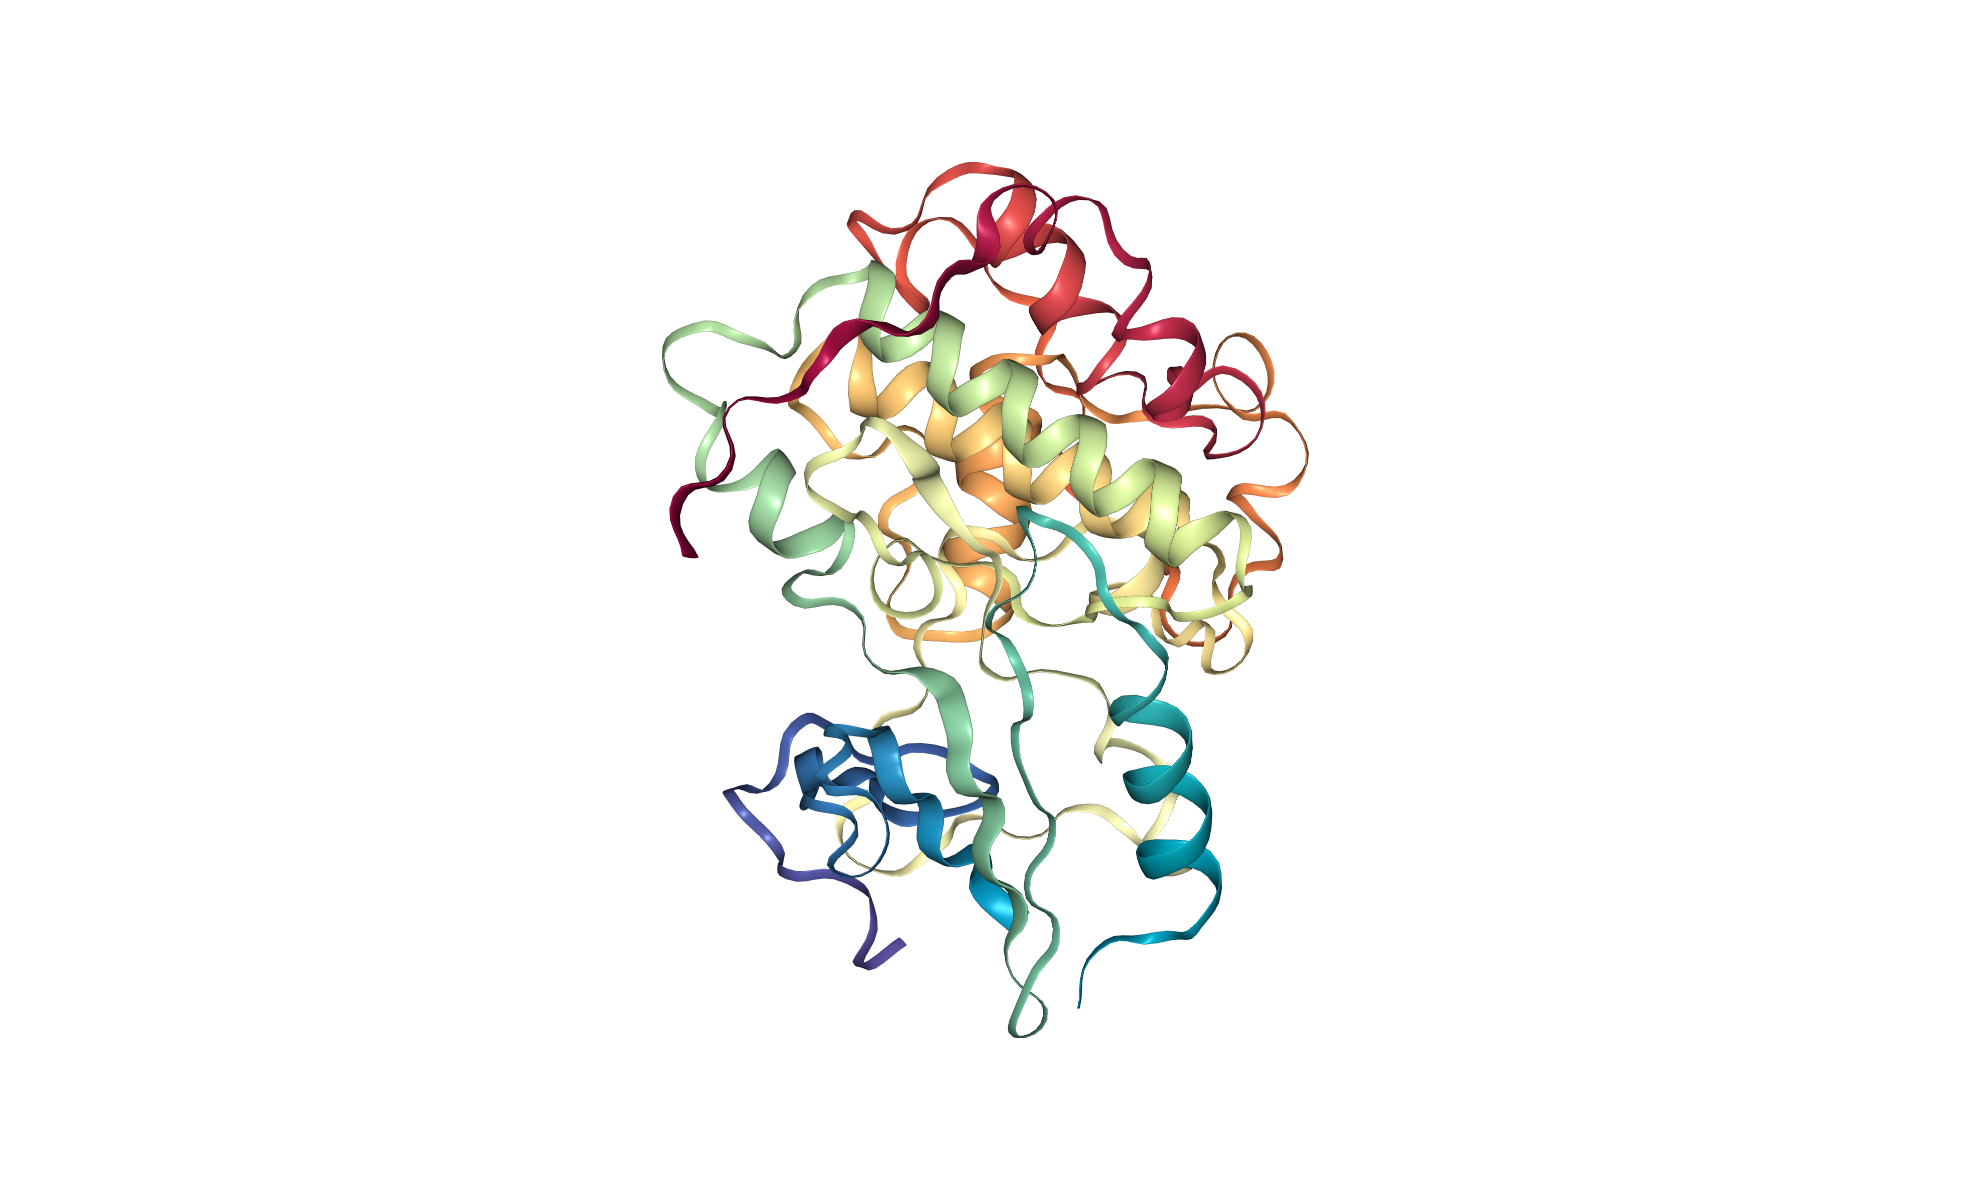

In [32]:
view1.render_image()
view1._display_image()

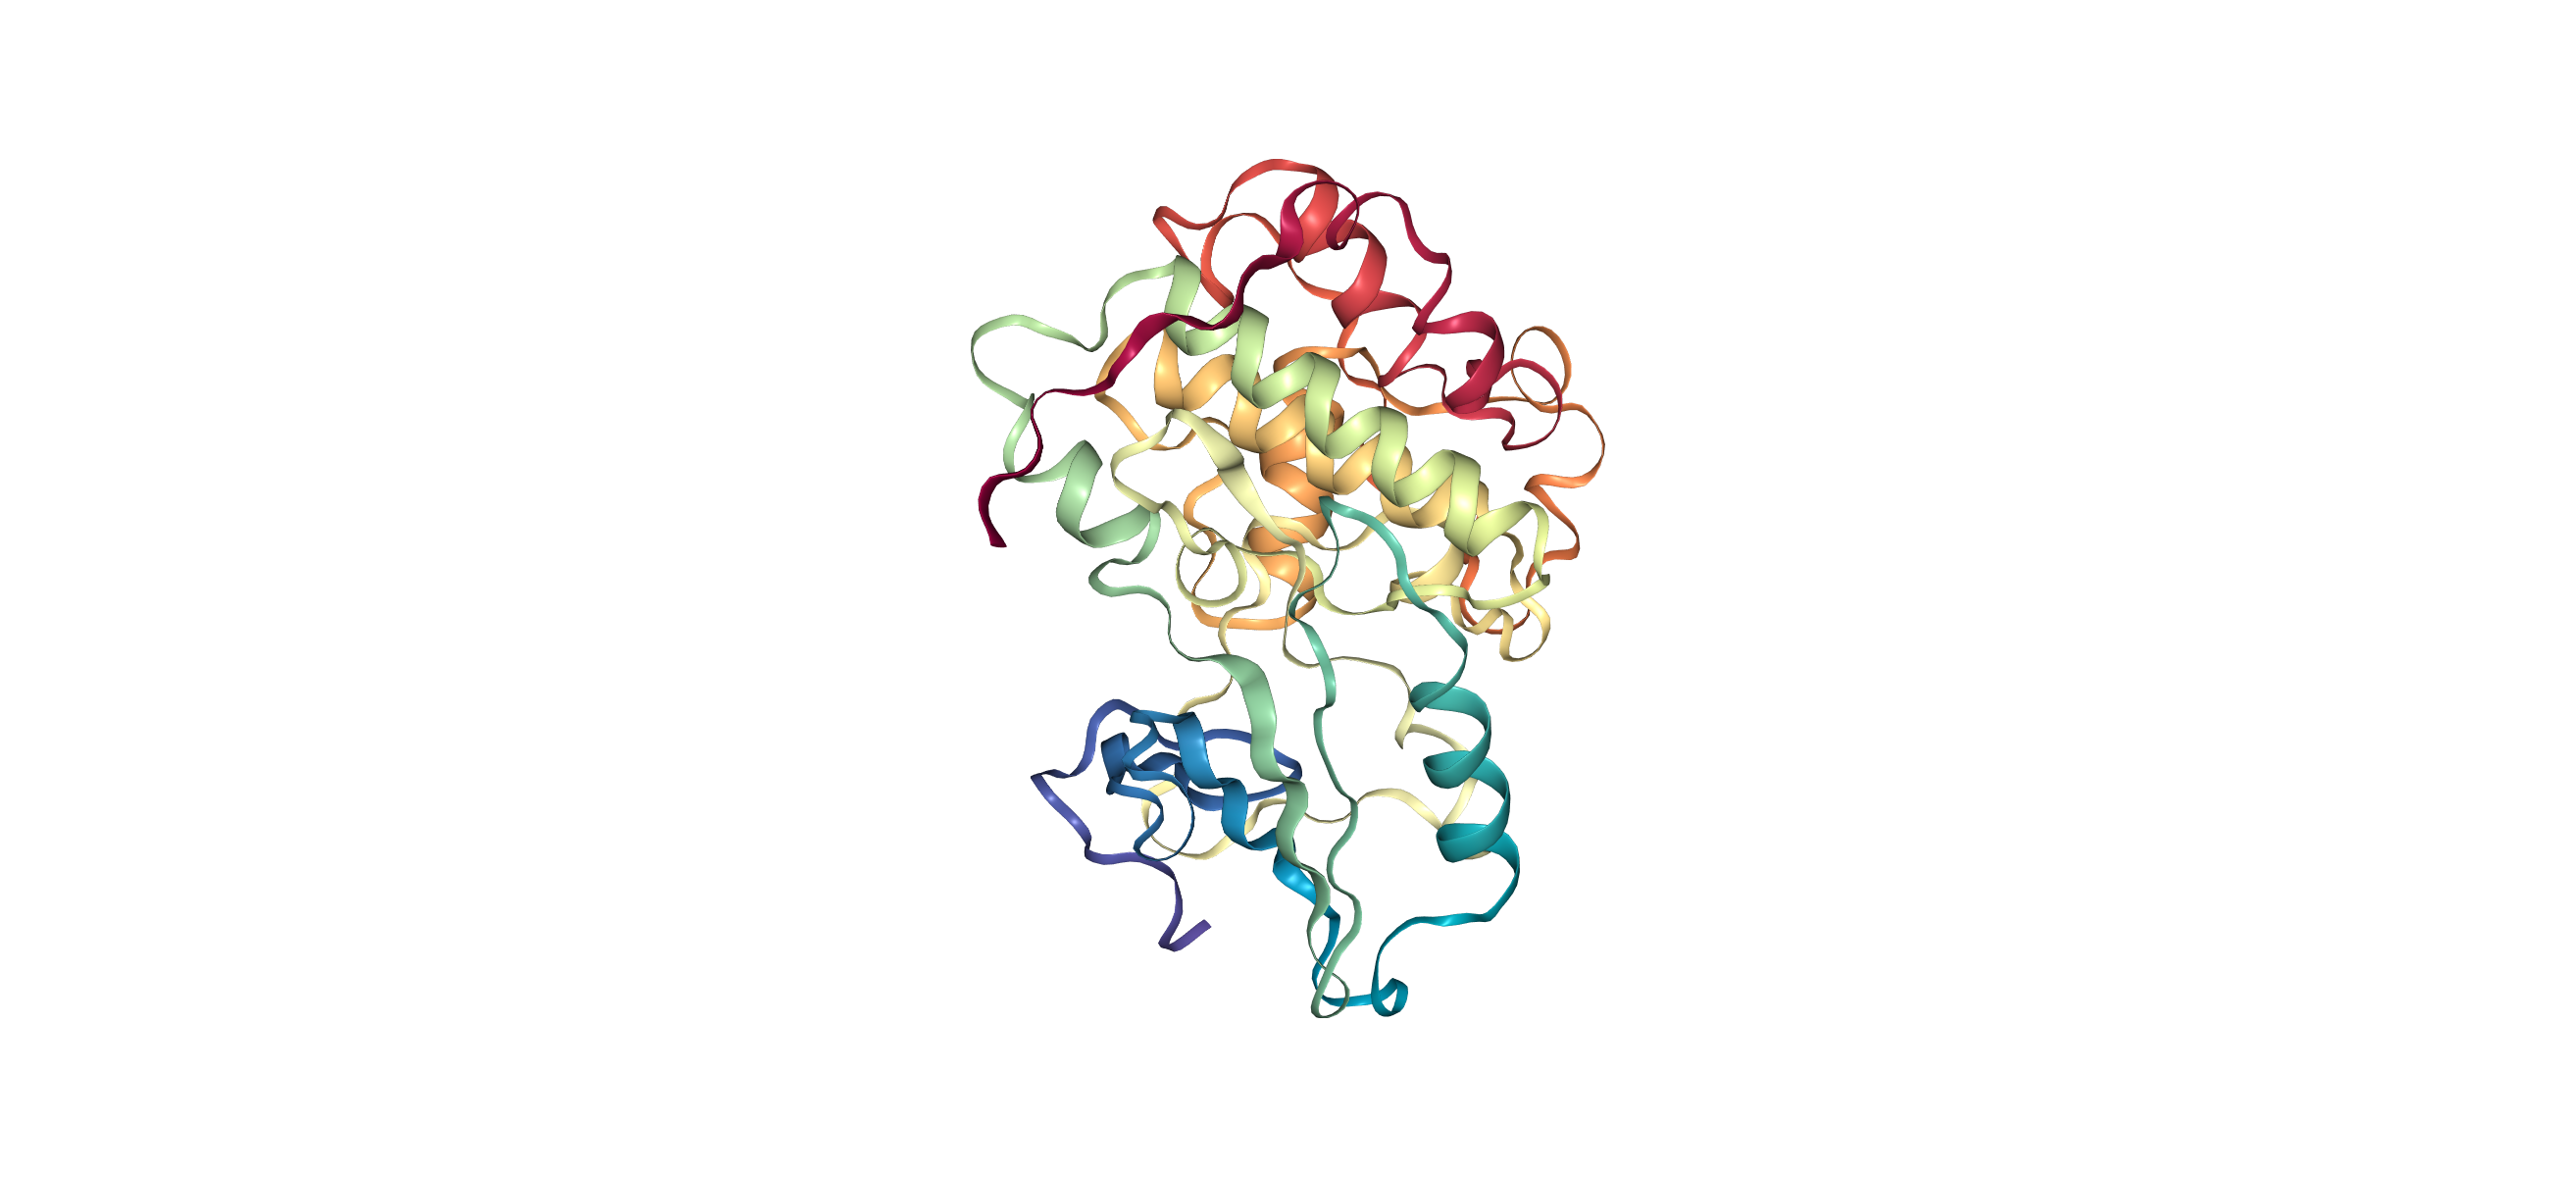

In [33]:
view2.render_image()
view2._display_image()

## Prepare the protein using `PDB2PQR`

In [10]:
# Prepare the protein using PDB2PQR
from helper_modules.prepare_md_system import run_pdb2pqr
OUT_PDB2PQR = 'prot.TEMP'
run_pdb2pqr(input_pdb = OUT_MODELLER_PDB,  
            output_basename = f'{TMP_DIR}/{OUT_PDB2PQR}',
            ph = PH,
            verbose = True)

INFO:PDB2PQR v3.4.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: ./4fku-WAT_intermediate_files/4fku_A_mod.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: 'Ato'
ERROR:<REMARK AtomGroup 4fku_A_mod>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Dropping water from structure.
INFO:Setting up molecule.
INFO:Created biomolecule object with 298 residues and 2398 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:This biomolecule is clean.  No r

In [34]:
# Visualize the protein
view1 = nglview.show_structure_file(OUT_MODELLER_PDB)
view1.add_representation(repr_type='ball+stick', selection='all')
view1._remote_call('setSize', target='Widget', args=['','300px'])
view1.camera='orthographic'
view1.render_image()

view2 = nglview.show_structure_file(f'{TMP_DIR}/{OUT_PDB2PQR}.pdb')
view2.add_representation(repr_type='ball+stick', selection='all')
view2._remote_call('setSize', target='Widget', args=['','300px'])
view2.camera='orthographic'
view2.render_image()

ipywidgets.HBox([view1, view2])

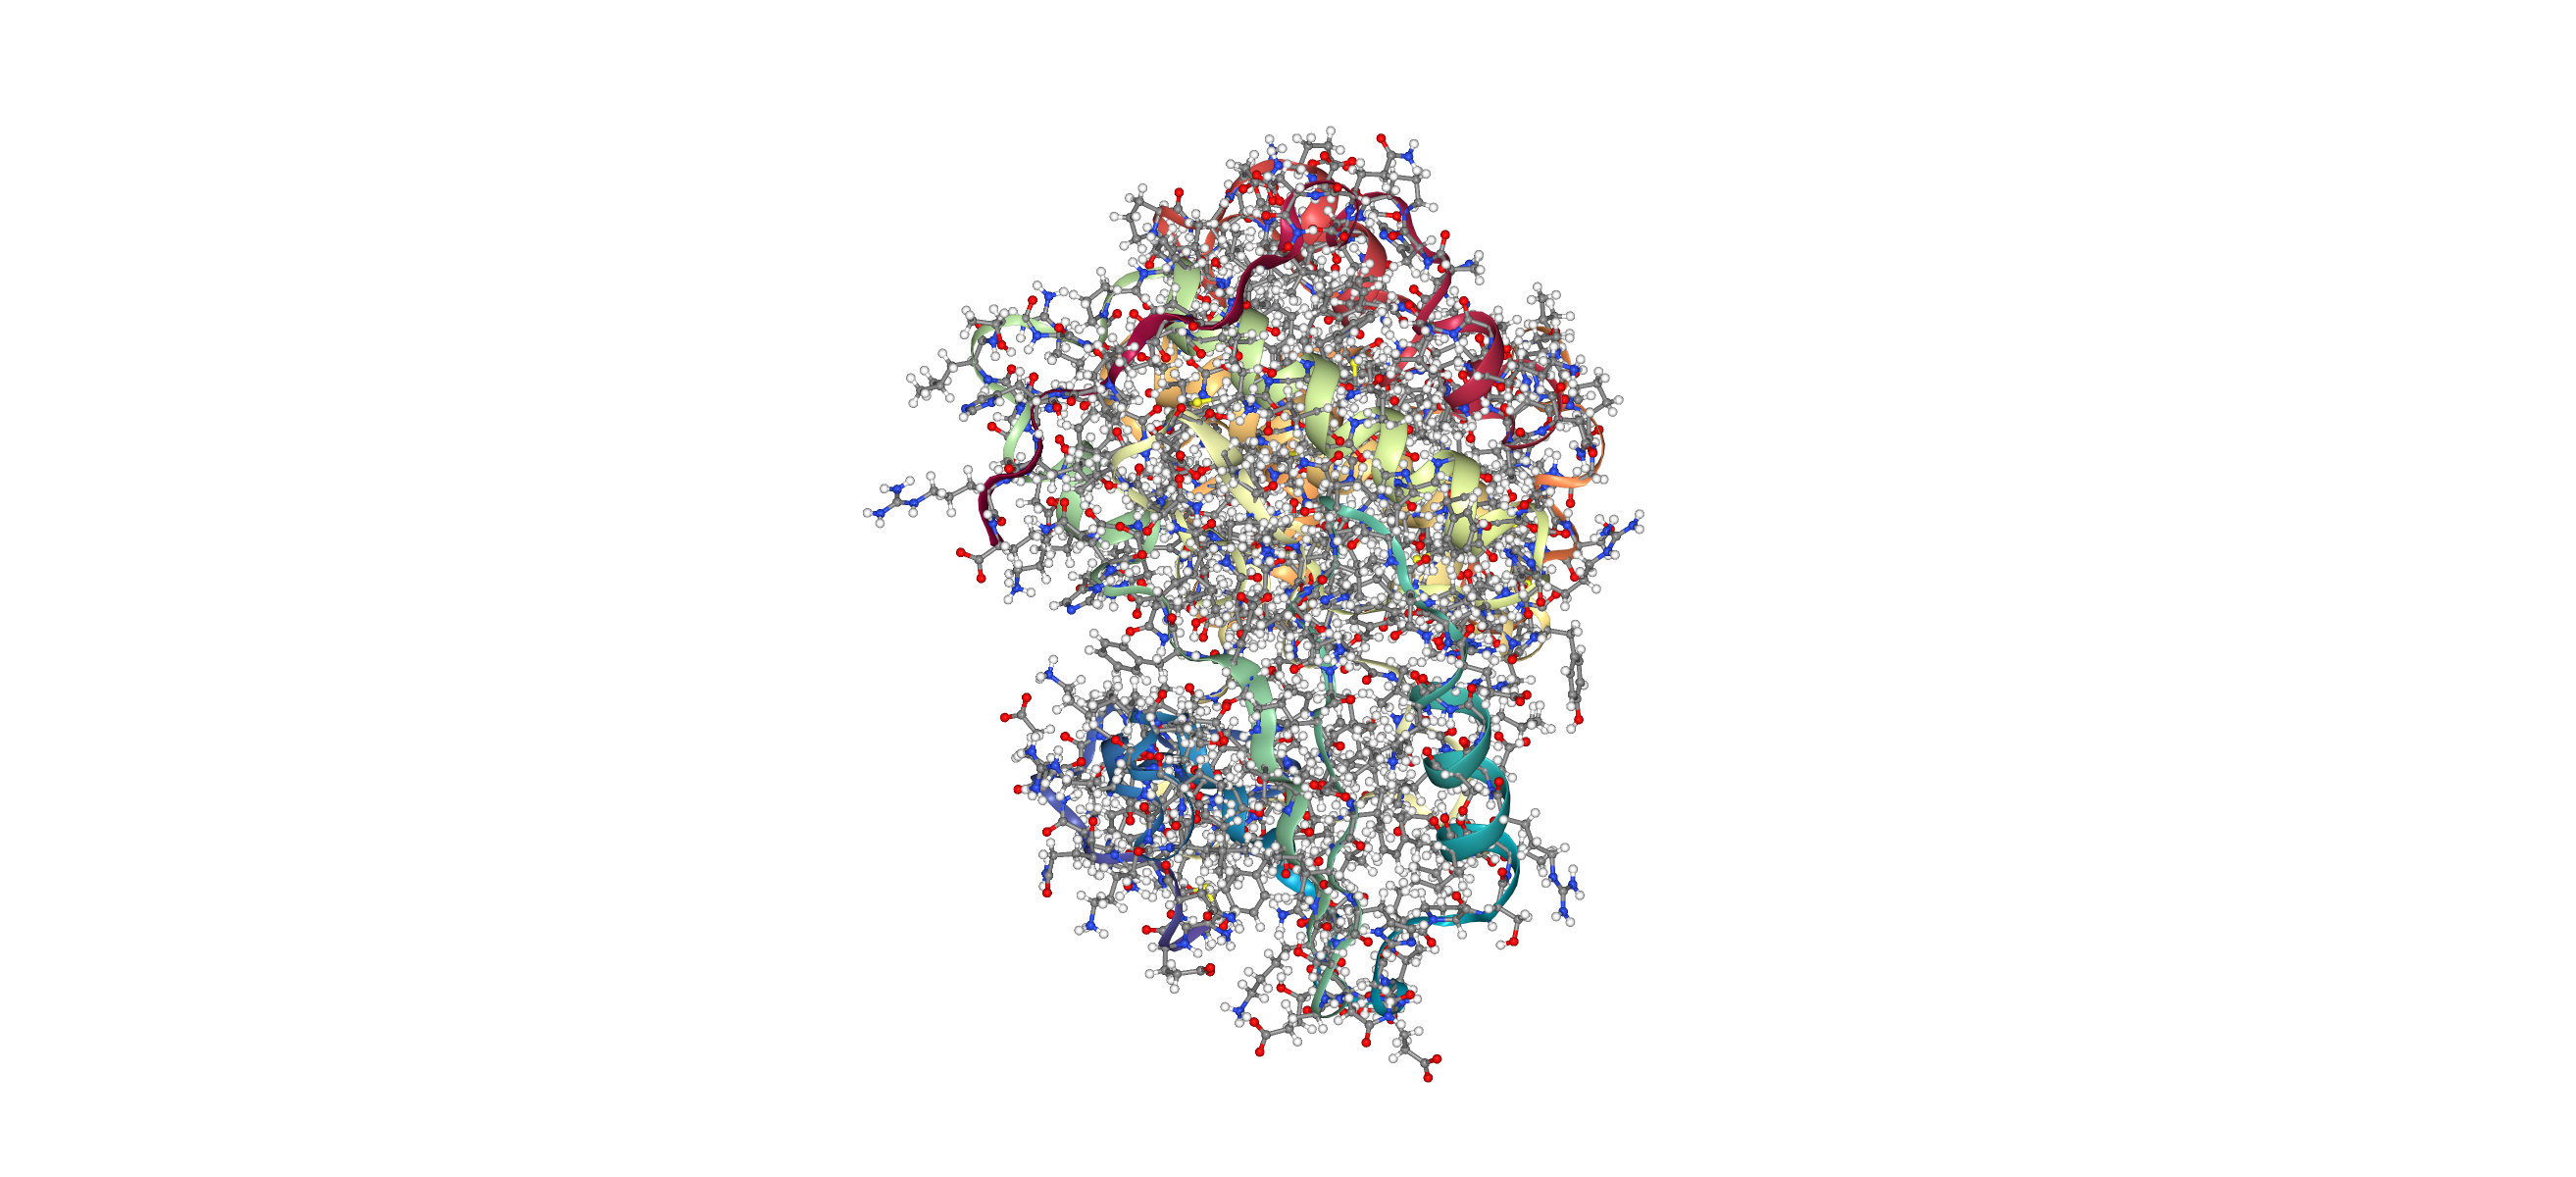

In [35]:
view2.render_image()
view2._display_image()

## Prepare protein topology file using `tleap`
- Use the `ff14SB` forcefield

In [13]:
from helper_modules.prepare_md_system import run_tleap_prepare_system
OUT_SYSTEM = 'SYSTEM'
run_tleap_prepare_system(
    input_protein_pdb  = 'prot.TEMP.pdb',
    output_basename    = OUT_SYSTEM, 
    tmp_dir            = TMP_DIR, 
    input_ligand_basename = None,
    input_waters_pdb      = None,
    verbose               = True
)

-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/prep to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/lib to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/parm to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd to search path.
-f: Source ./4fku-WAT_intermediate_files/leap_prep_system.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./4fku-WAT_intermediate_files/leap_prep_system.in
----- Source: /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/frcmod.ff14SB
Reading force field modification type file (frcmod)
Reading title:
ff14SB prot

## Minimize hydrogens

**Hydrogen minimization**, applying position restraints (50 $Kcal/mol\cdotÅ^2$) to the protein heavy atoms.

```fortran
    Taken from  biobb_amber module from the BioBB library
    Type of mdin: min_vacuo
    &cntrl
        imin = 1 
        ncyc = 250 
        ntb  = 0 
        igb  = 0 
        cut  = 12 
        maxcyc = 500 
        ntpr = 5 
        ntr  = 1 
        restraintmask = ":*&!@H=" 
        restraint_wt = 500.0 
    &end
```

In [14]:
from helper_modules.prepare_md_system import run_minimize_hydrogens

OUT_MIN_SYSTEM = f'{OUT_SYSTEM}.minH'
run_minimize_hydrogens(input_basename  = OUT_SYSTEM, 
                       output_basename = OUT_MIN_SYSTEM,
                       tmp_dir = TMP_DIR,
                       verbose = False)

In [15]:
from biobb_amber.process.process_minout import process_minout

process_minout(input_log_path  = f'{TMP_DIR}/sander.minH.log',
               output_dat_path = f'{TMP_DIR}/sander.minH.dat',
               properties      = {'terms': ['ENERGY']})

with open(f'{TMP_DIR}/sander.minH.dat', 'r') as energy_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in energy_file 
            if not line.startswith(("#","@")) 
            if float(line.split()[1]) < 1000 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = {
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Energy Minimization",
                        xaxis=dict(title = "Energy Minimization Step"),
                        yaxis=dict(title = "Potential Energy kcal/mol")
                       )
}

plotly.offline.iplot(fig)

2022-04-06 07:30:20,120 [MainThread  ] [INFO ]  Creating command line with instructions and required arguments
2022-04-06 07:30:20,269 [MainThread  ] [INFO ]  process_minout.perl  ./4fku-WAT_intermediate_files/sander.minH.log

2022-04-06 07:30:20,275 [MainThread  ] [INFO ]  Exit code 0

2022-04-06 07:30:20,280 [MainThread  ] [INFO ]  Processing sander output file (./4fku-WAT_intermediate_files/sander.minH.log)...
Processing step 50 of a possible 500...
Processing step 100 of a possible 500...
Processing step 150 of a possible 500...
Processing step 200 of a possible 500...
Processing step 250 of a possible 500...
Processing step 300 of a possible 500...
Processing step 350 of a possible 500...
Processing step 400 of a possible 500...
Processing step 450 of a possible 500...
Processing step 500 of a possible 500...
Processing step 500 of a possible 500...
Starting output...
Outputing summary.NSTEP
Outputing summary.ENERGY
Outputing summary.RMS
Outputing summary.GMAX
Outputing summary.NA

## Solvate the system

- `water_type` = `tip3p` water model
- `box_type` = truncated octahedron 
- Padding distance of 1.2 nm.

In [16]:
from helper_modules.prepare_md_system import run_leap_solv
OUT_PL_SOLV  = 'SOLV'
run_leap_solv(input_basename  = OUT_MIN_SYSTEM,
              output_basename = OUT_PL_SOLV, 
              box_padding     = BOX_PADDING,
              solvent_type    = SOLVENT_TYPE,
              input_ligand_basename = None,
              tmp_dir = TMP_DIR)

-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/prep to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/lib to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/parm to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd to search path.
-f: Source ./4fku-WAT_intermediate_files/leap_prep_SOLV.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./4fku-WAT_intermediate_files/leap_prep_SOLV.in
----- Source: /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/frcmod.ff14SB
Reading force field modification type file (frcmod)
Reading title:
ff14SB protein 

## Adding ions
- Get the number of water molecules inside the system
- In this example, the **net charge** of the protein is <mark>-4</mark>.
- To Neutralize the system, four `Cl-` atoms need to be added.


- To achieve a `ION_MOLAR` = $0.15 M$ of NaCl we'll employ the following computation:
    - `N_WATERS` / (55.3419 * `ION_MOLAR`)

In [17]:
from helper_modules.prepare_md_system import run_count_water_molecules

n_waters = run_count_water_molecules(f'{TMP_DIR}/{OUT_PL_SOLV}.pdb')
print('Number of water molecules:', n_waters)

w_molar_mass  = 18.01528 # g/mol
w_density     = 0.997    # g/mL
n_wat_mols_1L = (w_density / w_molar_mass) * 1000 # nW/L
n_ions        = int(n_waters / n_wat_mols_1L * ION_MOLAR) # nIONS
n_ions

Number of water molecules: 12375


33

### Neutralize the system with `NaCl`

In [18]:
from helper_modules.prepare_md_system import run_leap_neutralization
OUT_PL_NEUTRAL = 'NEUTRAL'
run_leap_neutralization(input_basename    = OUT_PL_SOLV, 
                        output_basename   = OUT_PL_NEUTRAL, 
                        tmp_dir           = TMP_DIR, 
                        solvent_type      = SOLVENT_TYPE,
                        ion_concentration = ION_MOLAR)

-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/prep to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/lib to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/parm to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd to search path.
-f: Source ./4fku-WAT_intermediate_files/leap_prep_NEUTRAL.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./4fku-WAT_intermediate_files/leap_prep_NEUTRAL.in
----- Source: /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/frcmod.ff14SB
Reading force field modification type file (frcmod)
Reading title:
ff14SB pr

In [36]:
view = nglview.show_structure_file(f'{TMP_DIR}/{OUT_PL_NEUTRAL}.pdb')
view.clear_representations()
view.add_representation(repr_type ='cartoon', selection='protein')
view.add_representation(repr_type ='line', selection='WAT')
view.add_representation(repr_type ='spacefill', selection='Cl- Na+')
view._remote_call('setSize', target='Widget', args=['','600px'])

view

NGLWidget()

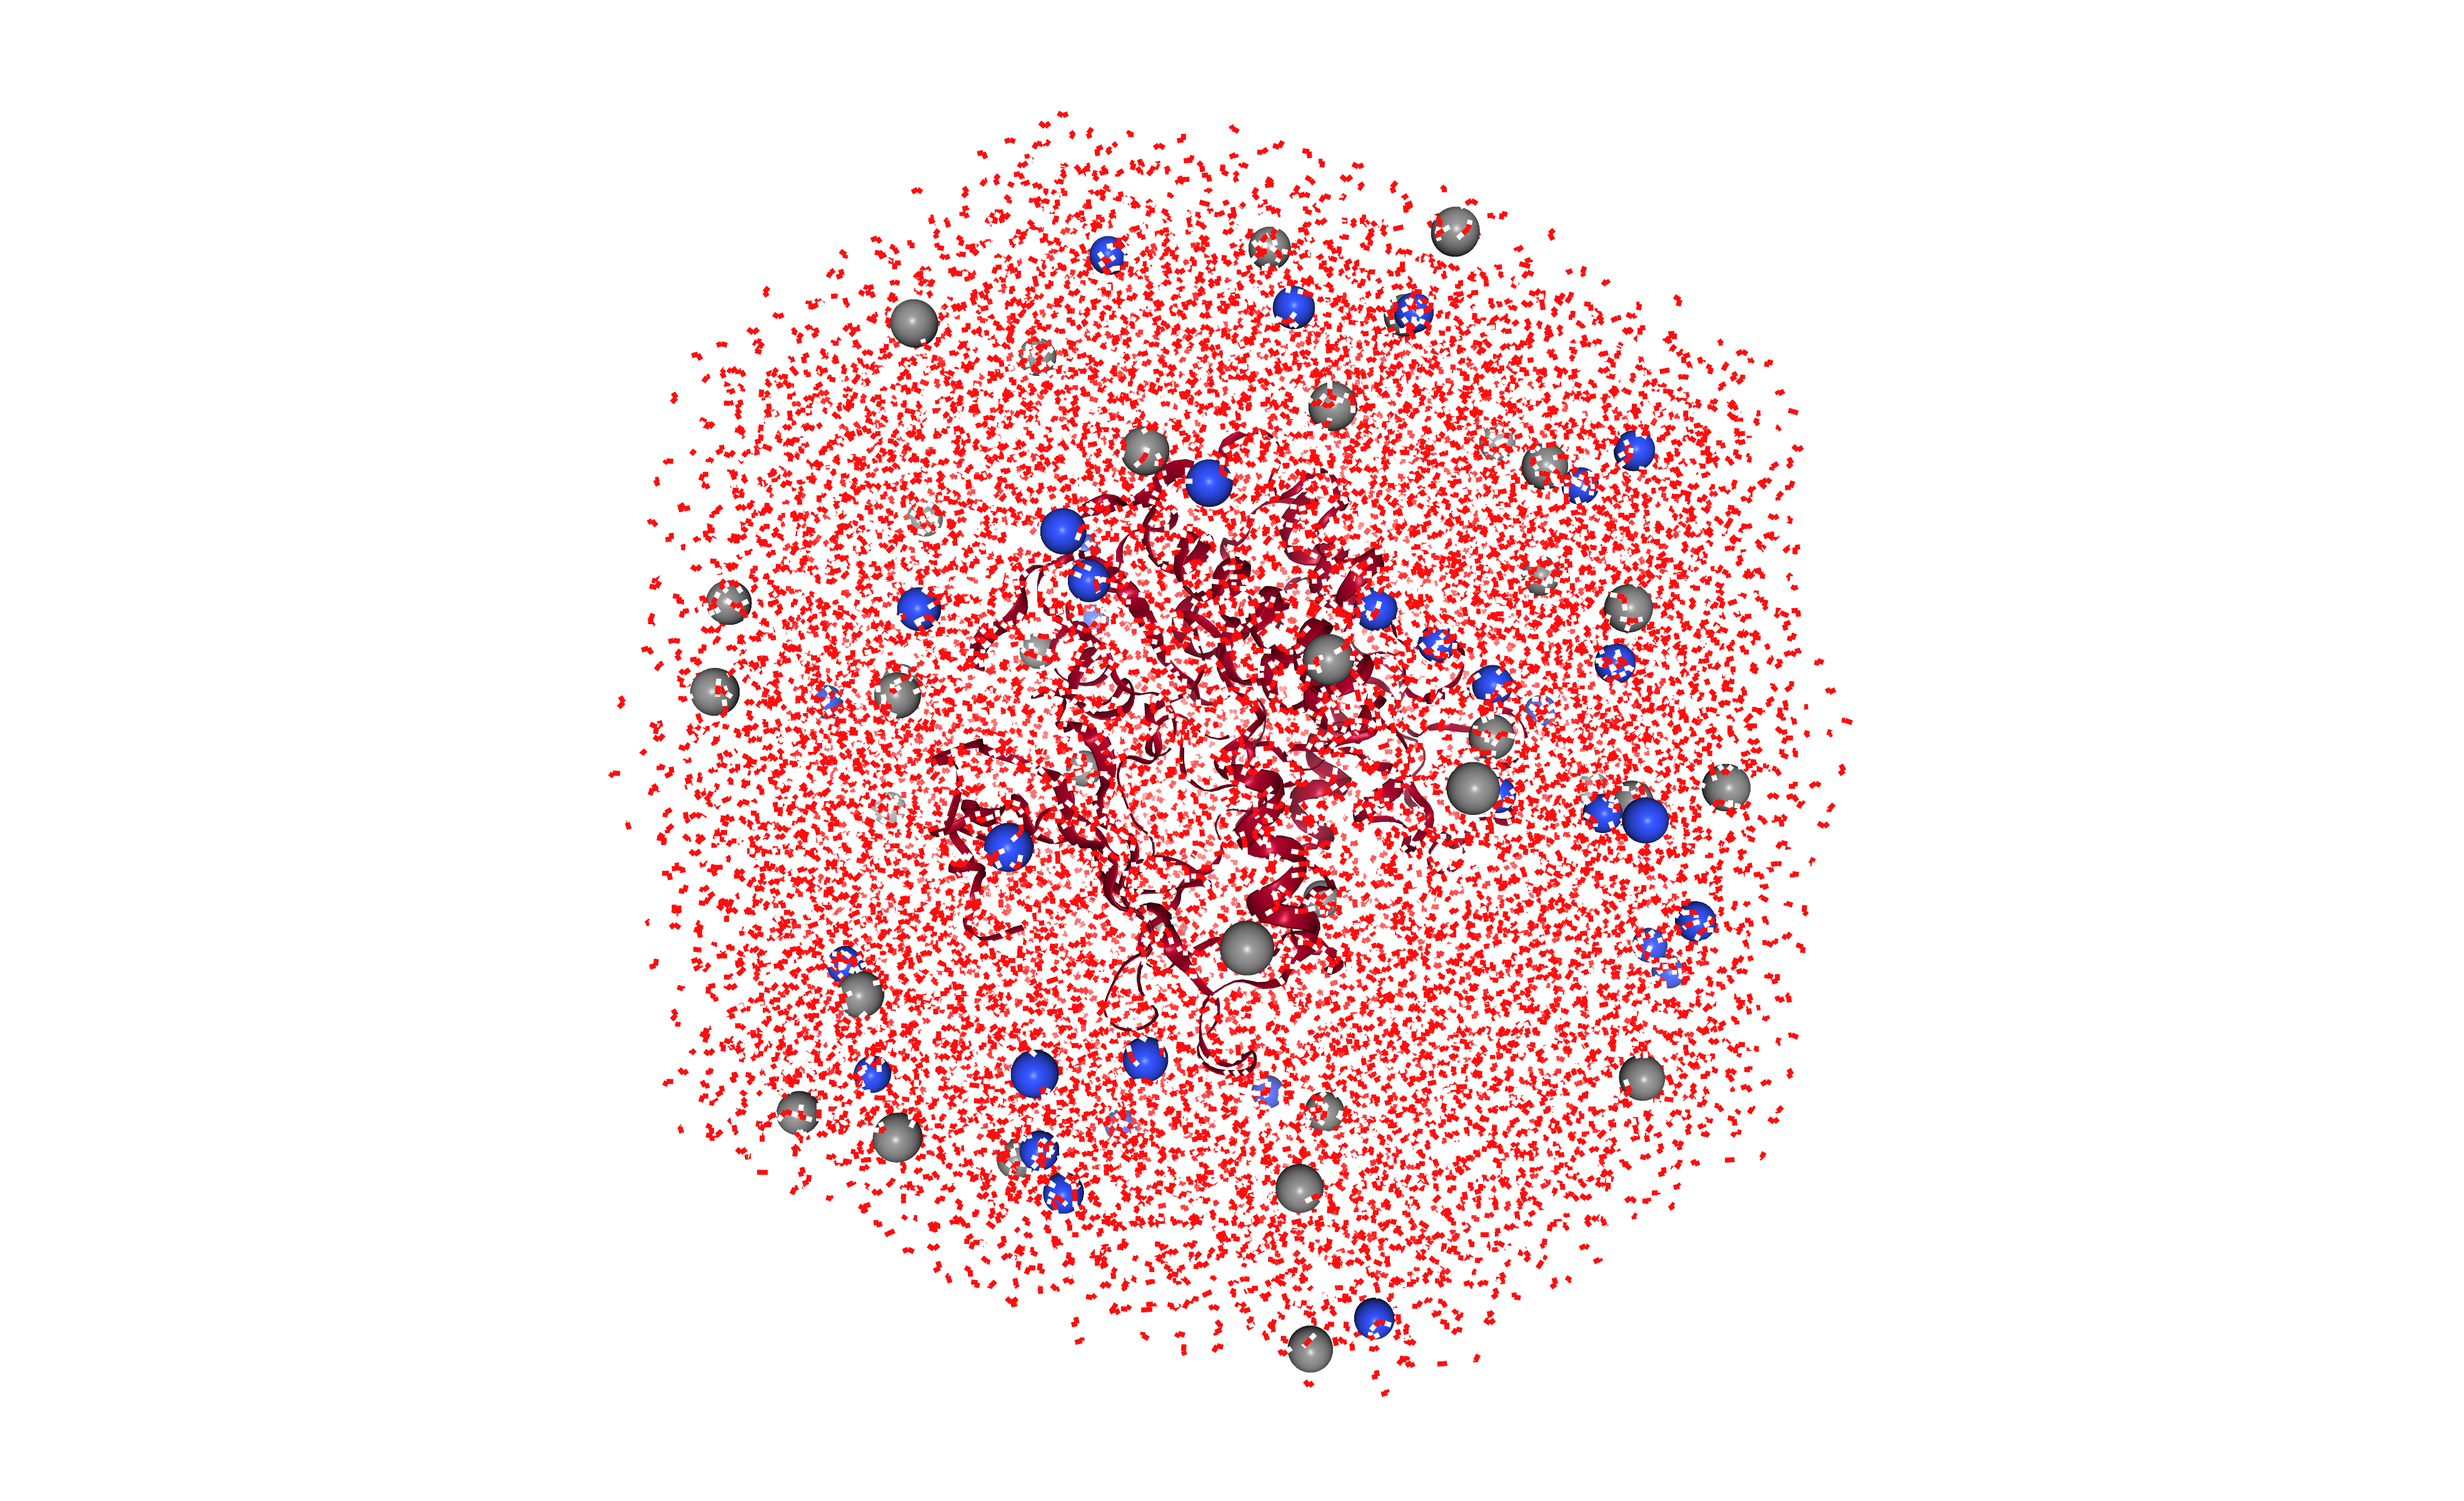

In [38]:
view.render_image()
view._display_image()

### Center the system to the origin

In [21]:
from helper_modules.prepare_md_system import run_center_system_to_origin

run_center_system_to_origin(
            filename = f'{TMP_DIR}/{OUT_PL_NEUTRAL}.rst7',
            topology = f'{TMP_DIR}/{OUT_PL_NEUTRAL}.prmtop',
            out_filename = f'{TMP_DIR}/{OUT_PL_NEUTRAL}.CENTERED.rst7')

Moving system to origin (44.00, 50.82, 51.98) -> (0,0,0)


## Use `ParmEd` to parse from Amber to Gromacs 

In [25]:
# Conver to gromacs
import parmed as pmd

top  = f'{TMP_DIR}/{OUT_PL_NEUTRAL}.prmtop'
rst7 = f'{TMP_DIR}/{OUT_PL_NEUTRAL}.CENTERED.rst7.1'

amber = pmd.load_file(top, rst7)
#save a GROMACS topology and GRO file
TOP_FILE = f'{TMP_DIR}/{FINAL_BASENAME}_NO_POSRES.top'
FINAL_GRO_FILE = f'{WD}/{FINAL_BASENAME}.gro'
amber.save(TOP_FILE)
amber.save(FINAL_GRO_FILE)

### Include `posres.itp` to the topology file

- Include the following lines inside the `.top` file, just below the protein definition
```algol60
; Include Position restraint file for protein
#ifdef POSRES
#include "posre.itp"
#endif
```

In [26]:
from parmed.gromacs import GromacsTopologyFile
top = GromacsTopologyFile(TOP_FILE)
top.molecules.keys()

dict_keys(['system1', 'Na+', 'Cl-', 'WAT'])

### Create and include the `posres.itp` file

In [27]:
from helper_modules.prepare_md_system import include_posre_in_top, create_posre_file

FINAL_TOP_FILE = f'{WD}/{FINAL_BASENAME}.top'
# Protein posres
PROT_POSRE_FILE = f'{FINAL_BASENAME}.prot_posre.itp'
create_posre_file(input_gro          = FINAL_GRO_FILE, 
                  out_posre_filename = f'{WD}/{PROT_POSRE_FILE}',
                  mol_selection      = 'protein',
                  rest_energies      = [1000, 1000, 1000],
                  verbose = False)
include_posre_in_top(input_top_file = TOP_FILE, 
                     out_top_file   = FINAL_TOP_FILE, 
                     posre_filename = PROT_POSRE_FILE,
                     molecule_index = 1 # idx=1 for protein
                    )

### Print some properties of the final system

In [28]:
# Get the protein charge
import re

def get_log_lines(file, 
                  pattern, 
                  lines_list = [0]):
    log_lines = []
    with open(file,"r") as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if re.search(pattern, line):
                for j in lines_list:
                    log_lines.append(lines[i + j])
    return log_lines



In [29]:
# Report Logs
file = f'{TMP_DIR}/leap_prep_{OUT_SYSTEM}.in.log'

# Protein charge
pattern = 'charge protein'
protein_charge = get_log_lines(file, pattern, lines_list = [1])
protein_charge = protein_charge[0].replace('\n', '').split(' ')[-1]
protein_charge= [f'\nProtein Net Charge: {protein_charge}']

# Total protein atoms
pattern = 'total atoms in file'
n_protein_atoms = get_log_lines(file, pattern, lines_list = [0])
n_protein_atoms = n_protein_atoms[0].strip().split(' ')[-1]
n_protein_atoms = [f'\nNumber of Protein atoms: {n_protein_atoms}']


file = f'{TMP_DIR}/leap_prep_{OUT_PL_NEUTRAL}.in.log'

# Total protein atoms
pattern = 'total atoms in file'
n_total_atoms = get_log_lines(file, pattern, lines_list = [0])
n_total_atoms = n_total_atoms[0].strip().split(' ')[-1]
n_total_atoms = [f'\nTotal Number of atoms: {n_total_atoms}']

# System charge
pattern = 'charge system'
system_charge = get_log_lines(file, pattern, lines_list = [1])
system_charge = system_charge[0].replace('\n', '').split(' ')[-1]
system_charge = [f'\nSystem Net Charge: {system_charge}']

# Box dimensions
pattern = 'Box dimensions'
box_dimensions = get_log_lines(file, pattern, lines_list = [0])
box_dimensions = box_dimensions[0].split(' ')[-3:]
box_dimensions = [f'- {c}: {b}\n' for b, c in zip(box_dimensions, ['x', 'y', 'z'])]
box_dimensions.insert(0, pattern + ':\n')

# Warnings
pattern = 'Warning!'
warnings = get_log_lines(file, pattern, lines_list = [1])
warnings.insert(0, '\nWarnings:')

# Number of final waters
pattern = '\tWAT'
n_waters = get_log_lines(file, pattern, lines_list = [0])
n_waters = [n_waters[0].strip()]
n_waters.insert(0, '\nNumber of WAT molecules:')

# Number of ions
pattern = 'Placed Na+'
n_Na = [str(len(get_log_lines(file, pattern, lines_list = [0])))]
n_Na.insert(0, '\nNumber of Na+ ions:')

pattern = 'Placed Cl-'
n_Cl = [str(len(get_log_lines(file, pattern, lines_list = [0])))]
n_Cl.insert(0, '\nNumber of Cl- ions:')

# Number of cosolvent molecules
solv_lines = []
if SOLVENT != None and SOLVENT != 'WAT':
    pattern = f'\t{SOLVENT}'
    solv_lines = get_log_lines(file, pattern, lines_list = [0])
    solv_lines = [solv_lines[0].strip()]
    solv_lines.insert(0, f'\nNumber of {SOLVENT} molecules:')
    
LINES = protein_charge + system_charge + n_protein_atoms + n_total_atoms +\
        n_waters + solv_lines +\
        n_Na + n_Cl + box_dimensions + warnings
        
with open(f'{TMP_DIR}/PREP_SUMMARY.log', 'w') as f:
    f.writelines(LINES)
    
for l in LINES:
    print(l)


Protein Net Charge: 4.000000

System Net Charge: -0.000000

Number of Protein atoms: 4848

Total Number of atoms: 41973

Number of WAT molecules:
WAT	12305

Number of Na+ ions:
33

Number of Cl- ions:
37
Box dimensions:

- x: 87.825600

- y: 100.735600

- z: 104.204600



Warnings:
 Converting N-terminal residue name to PDB format: NMET -> MET

 Converting C-terminal residue name to PDB format: CLEU -> LEU

